In [137]:
import torch
import numpy as np
import torch.nn as nn
import networkx as nx
import pandas as pd
import scipy.linalg as LIN
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.weight'] = 'medium'

%matplotlib inline

In [2]:
np.random.seed(1)

In [9]:
# get left and right eigenvectors associated with the 
# largest eigenvalue. 
def getLREigVec(mat):
    eigVals_, eigL_, eigR_ = LIN.eig(mat, left=True)
    idx_max = np.argmax(eigVals_)
    t = eigL_[:, idx_max]
    h = eigR_[:, idx_max]
    return t, h

# compute gradient
def gradient(adjMat, S, Alpha, J):
    n = adjMat.shape[0]
    alpha1, alpha2, alpha3 = Alpha
    I = np.identity(n)
    
    ## for 1st term, to increase the largest eigenvalue
    ## of the subgraph
    S_adjMat = adjMat[np.ix_(S, S)]
    t_S, h_S = getLREigVec(S_adjMat)
    c_1 = np.dot(t_S, h_S)
    P_1 = np.outer(t_S, h_S)
    g_1 = np.zeros(adjMat.shape)
    g_1[np.ix_(S, S)] = (P_1 + np.transpose(P_1) - np.multiply(P_1, np.identity(len(S)))) / c_1
    g_1 = np.multiply(g_1, J)

    ## for 2nd term, to not increase the largest eigenvalue
    ## too much
    t, h = getLREigVec(adjMat)
    c_2 = np.dot(t, h)
    P_2 = np.outer(t, h)
    g_2 = ( P_2 + np.transpose(P_2) - np.multiply(P_2, I) ) / c_2
    g_2 = np.multiply(g_2, J)

    ## for 3rd term, to increase the centrality of the subgraph
    x_S = np.zeros(len(G.nodes))
    x_S[S] = 1
    X_S = np.outer(x_S, x_S)
    P_3 = np.transpose( 2 * X_S - (np.multiply(X_S, I)) )
    g_3 = np.dot(np.multiply(P_3, I), np.ones((n, n))) - P_3
    g_3 = g_3 + np.transpose(g_3) - np.multiply(g_3, I)
    # no need to change the edges' weights within the subgraph
#     g_3[np.ix_(S, S)] = 0
    g_3 = np.multiply(g_3, J)
    
    g = np.real( alpha1 * g_1 - alpha2 * g_2 + (alpha3/len(S)) * g_3 )
    return g

# get the largest eigenvalue
def maxEig(mat):
    eigVals = LIN.eigvals(mat)
    return np.max(eigVals)

# get a submatrix of mat indexed by S
def getSubmat(mat, S):
    return mat[np.ix_(S, S)]

# get the Laplacian matrix corresponding to mat
def getL(mat):
    degsVec = np.dot(mat, np.ones(mat.shape[1]))
    return np.diag(degsVec) - mat

# compute centrality
def getCent(L, x_S):
    return np.real( np.dot(x_S, np.dot(L, x_S)) / len(S) )

In [10]:
n = 100
G = nx.barabasi_albert_graph(n, 2)

adjMat = np.asarray(nx.adjacency_matrix(G).todense())
J = np.copy(adjMat)
    
# trade-off parameters
alpha1, alpha2, alpha3 = 0, 0, 1
ret = {'Lambda': [], 'Lambda_S': [], 'Centrality': [], 'Utility': []}
Gradient = []

# subgraph is the induced subgraph of S
center = np.random.choice(range(G.order()))
S = list(G.neighbors(center)) + [center]
# S = [1, 2, 3]
# x_S is the characteristic vector of S
x_S = np.zeros(len(G.nodes))
x_S[S] = 1

Iter = 100
lr = 0.1
adjMat_0 = np.copy(adjMat)

# gradient ascent 
for ii in range(Iter):
    # compute eigenvalues
    lambda_1 = np.real(maxEig(adjMat))
    lambda_1_S = np.real(maxEig(getSubmat(adjMat, S)))
    
    # compute centrality
    L = getL(adjMat)
    Cent = getCent(L, x_S)
    
    # compute utility
    utility = np.real( alpha1 * lambda_1_S - alpha2 * lambda_1 + alpha3 * Cent )
    
    # printing and recording intermediate results
    if ii % 10 == 0:
        print("Lambda_S: %.4f      Lambda: %.4f      Centrality: %i      Utility: %.4f" % (lambda_1_S, lambda_1, Cent, utility))
    ret['Lambda'].append(lambda_1)
    ret['Lambda_S'].append(lambda_1_S)
    ret['Centrality'].append(Cent)
    ret['Utility'].append(utility)
    
    # update gradient
    g = gradient(adjMat, S, [alpha1, alpha2, alpha3], J)
    Gradient.append(np.copy(g))
    adjMat = adjMat + lr * g


Lambda_S: 1.4142      Lambda: 6.6199      Centrality: 4      Utility: 4.0000
Lambda_S: 0.4714      Lambda: 6.8604      Centrality: 5      Utility: 5.3333
Lambda_S: 0.4714      Lambda: 7.2597      Centrality: 6      Utility: 6.6667
Lambda_S: 1.4142      Lambda: 7.8711      Centrality: 8      Utility: 8.0000
Lambda_S: 2.3570      Lambda: 8.6903      Centrality: 9      Utility: 9.3333
Lambda_S: 3.2998      Lambda: 9.6635      Centrality: 10      Utility: 10.6667
Lambda_S: 4.2426      Lambda: 10.7369      Centrality: 11      Utility: 12.0000
Lambda_S: 5.1854      Lambda: 11.8746      Centrality: 13      Utility: 13.3333
Lambda_S: 6.1283      Lambda: 13.0548      Centrality: 14      Utility: 14.6667
Lambda_S: 7.0711      Lambda: 14.2643      Centrality: 15      Utility: 16.0000


In [11]:
g[np.ix_(S, S)]

array([[ 0.        ,  0.        , -0.66666667],
       [ 0.        ,  0.        , -0.66666667],
       [-0.66666667, -0.66666667,  0.        ]])

In [15]:
idx = [0, 1, 2]
a = np.zeros(10)
a[idx] = 1
np.outer(a, a)

array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Text(0.5, 1.0, 'alpha_1=0.50  alpha_2=0.30  alpha_3=0.20')

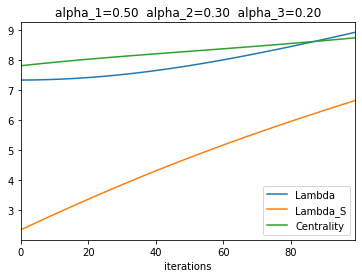

In [48]:
# plot results
ret[['Lambda', 'Lambda_S', 'Centrality']].plot(kind='line')
plt.xlabel('iterations')
plt.title('alpha_1=%.2f  alpha_2=%.2f  alpha_3=%.2f' % (alpha1, alpha2, alpha3))
# plt.savefig('../ret/5-3-2.pdf')

#  This Line below is irrelevant

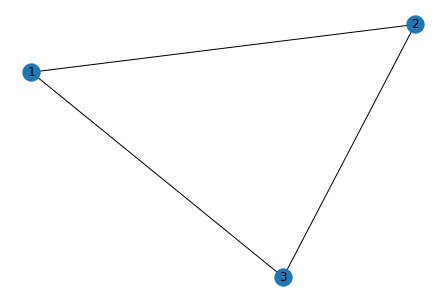

In [57]:
G = nx.Graph()
G.add_nodes_from([1, 2, 3])
G.add_edges_from([(1,2), (1, 3), (2, 3)])
nx.draw(G, with_labels=True)

In [58]:
A = np.asarray( nx.adjacency_matrix(G).todense() )
L = np.asarray( nx.laplacian_matrix(G).todense() )

In [85]:
xs = np.zeros(3)
xs[[0, 1]] = 1

In [86]:
np.dot(xs, np.dot(L, xs))

2.0

In [92]:
XS = np.outer(xs, xs)
P = np.transpose( 2 * XS - (np.multiply(XS, np.identity(3))) )

a = np.dot(np.multiply(P, np.identity(3)), np.ones((3, 3)))
g = a - P
g = g + np.transpose(g) - np.multiply(g, np.identity(3))
g = np.multiply(g, A)
g

array([[ 0., -2.,  1.],
       [-2.,  0.,  1.],
       [ 1.,  1.,  0.]])

In [93]:
# Delta = np.zeros((3,3))
# Delta[0, 1] = 1
# L_tilde = getL(A + Delta)
Delta = 0.1 * g
L_tilde = getL(A + Delta)
np.dot(xs, np.dot(L_tilde, xs)) - np.dot(xs, np.dot(L, xs)) 

0.20000000000000018

In [79]:
np.trace(np.dot(Delta, XS))

6.0

In [61]:
eigVals_, eigL_, eigR_ = LIN.eig(L, left=True)

In [63]:
np.dot(eigR_, np.transpose(eigR_))

array([[ 1.0958487 , -0.25049315,  0.15464445],
       [-0.25049315,  1.15464445,  0.0958487 ],
       [ 0.15464445,  0.0958487 ,  0.74950685]])

In [65]:
T = np.zeros((3,3))
for i in range(3):
    T = T + np.outer(eigR_[:, i], eigR_[:, i])
T

array([[ 1.0958487 , -0.25049315,  0.15464445],
       [-0.25049315,  1.15464445,  0.0958487 ],
       [ 0.15464445,  0.0958487 ,  0.74950685]])

In [80]:
A

array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]], dtype=int64)

In [470]:
n = 128
G = nx.watts_strogatz_graph(n, 10, 0.2)
adj = nx.adjacency_matrix(G).todense()

alpha1, alpha2, alpha3 = 0.4, 0.4, 0.2

center = np.random.choice(range(G.order()))
S = list(G.neighbors(center)) + [center]
S_prime = list(set(G.nodes()) - set(S))
S = torch.LongTensor(S)
S_prime = torch.LongTensor(S_prime)

x_s = torch.zeros(n)
x_s[S] = 1


class Threat_Model(nn.Module):
    def __init__(self, S, S_prime, Alpha, budget, learning_rate, G):
        super(Threat_Model, self).__init__()
        self.S = S
        self.S_prime = S_prime
        self.alpha_1, self.alpha_2, self.alpha_3 = Alpha
        self.budget = budget
        self.learning_rate = learning_rate
        self.used_budget = 0
        
        self.lambda1_S_prime = 0
        self.lambda1_S = 0
        self.normalizedCut = 0
        self.lambda1 = 0
        
        adj = nx.adjacency_matrix(G).todense()
        self.mask = torch.tensor(adj, dtype=torch.float32)
        eigVals, eigVecs = torch.symeig(self.mask, eigenvectors=True)
        # eig-vector associated with the largest eig-value of A (since mask = A)
        self.eig_v = eigVecs[:, -1]
        self.original_lambda1 = eigVals[-1]
        
        self.adj_tensor = torch.tensor(adj, dtype=torch.float32).requires_grad_(True)
        self.adj_tensor = nn.Parameter(self.adj_tensor)
        # masking the gradients backpropagated to adj_tensor
        self.adj_tensor.register_hook(lambda x: x * self.mask)
        
    def forward(self):
        '''
            compute the loss function given current adjacency matrix
        '''
        # degree matrix
        D = torch.diag(torch.mm(self.adj_tensor, torch.ones(n).view(-1, 1)).squeeze())
        # Laplacian matrix
        L = D - self.adj_tensor
    
        # select the sub-matrix corresponding to S
        adj_tensor_S = torch.index_select(torch.index_select(self.adj_tensor, 0, self.S), 1, self.S)
        adj_tensor_S_prime = torch.index_select(torch.index_select(self.adj_tensor, 0, self.S_prime), 1, self.S_prime)
    
        # all sorts of largest eigenvalues 
        self.lambda1 = torch.max(torch.symeig(self.adj_tensor, eigenvectors=True)[0])
        self.lambda1_S = torch.max(torch.symeig(adj_tensor_S, eigenvectors=True)[0])
        self.lambda1_S_prime = torch.max(torch.symeig(adj_tensor_S_prime, eigenvectors=True)[0])
        
        # centrality measure
        self.normalizedCut = torch.mm(x_s.view(1, -1), torch.mm(L, x_s.view(-1, 1))) / (0.5 * adj_tensor_S.sum())
        Loss = -1 * (self.alpha_1 * self.lambda1_S - \
                     self.alpha_2 * self.lambda1_S_prime + self.alpha_3 * self.normalizedCut)
        return Loss
    
    
    # check if the attacker still has budget
    def update_used_budget(self):
        # make sure the attacker has made some attack
        if self.adj_tensor.grad != None:
            current_used_budget = \
                torch.abs(torch.mm(self.eig_v.view(1, -1), torch.mm(self.aggre_change, self.eig_v.view(-1, 1))))
            self.used_budget += current_used_budget 

    
    # return the results that we are interested in
    def getRet(self):
        return self.lambda1_S, self.lambda1, self.normalizedCut
    
    
    def get_used_budget(self):
        return torch.Tensor(self.used_budget).clone()
            
            
learning_rate = 1e-1
Alpha = [alpha1, alpha2, alpha3]
Attacker = Threat_Model(S, S_prime, Alpha, 0.1, learning_rate, G)
opt = torch.optim.Adam(Attacker.parameters(), lr=learning_rate)

ret = {'lambda_1': [], 'lambda_1_S': [], 'centrality': []}
Losses = []
for i in range(20):
    Loss = Attacker()
    Losses.append(Loss.item())
    lambda1_S, lambda1, normalizedCut = Attacker.getRet()
    ret['lambda_1'].append(lambda1.item())
    ret['lambda_1_S'].append(lambda1_S.item())
    ret['centrality'].append(normalizedCut.item())

    opt.zero_grad()
    Loss.backward()
    opt.step()
            
ret = pd.DataFrame(ret) 

In [471]:
ret

,lambda_1,lambda_1_S,centrality
0,10.163877,5.291664,2.190476
1,9.404421,5.820830,2.190477
2,9.040400,6.350277,2.189713
3,9.191995,6.880132,2.188003
4,9.567895,7.410502,2.185272
5,10.026572,7.941459,2.181514
6,10.524951,8.473045,2.176759
7,11.046058,9.005306,2.171059
8,11.581601,9.538264,2.164476
9,12.126884,10.071932,2.157076


Text(0.5, 1.0, 'alpha_1=0.40  alpha_2=0.40  alpha_3=0.20')

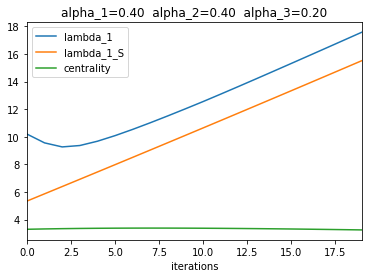

In [469]:
ret.plot(kind='line')
plt.xlabel('iterations')
plt.title('alpha_1=%.2f  alpha_2=%.2f  alpha_3=%.2f' % (alpha1, alpha2, alpha3))

In [132]:
g[np.ix_(S.numpy(), S.numpy())]

array([[ 0. ,  0. ,  0. , -0.5],
       [ 0. ,  0. , -0.5, -0.5],
       [ 0. , -0.5,  0. , -0.5],
       [-0.5, -0.5, -0.5,  0. ]])

In [134]:
np.where(adj_tensor.grad.numpy()[2, :])[0]

array([0, 1, 5, 7, 8, 9])

In [135]:
np.where(g[2,:])[0]

array([0, 1, 4, 7, 8, 9])